In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [2]:
### Load train & test data
# Load Training Data
df_train = pd.read_csv("train.csv")
df_train_encoded = df_train.copy()
df_train_encoded['Sex'] = LabelEncoder().fit_transform(df_train_encoded["Sex"])

# Load Testing Data
df_test = pd.read_csv("test.csv")
df_test_encoded = df_test.copy()
df_test_encoded['Sex'] = LabelEncoder().fit_transform(df_test_encoded["Sex"])

In [3]:
### Data preprocessing

## Training
# Copy data
df_train = df_train_encoded.copy()
df_test = df_test_encoded.copy()

# Define features & objective
X = df_train.drop(["Calories", "id"], axis=1)
Y = df_train["Calories"]

# Split data further for internal validation
X_train_full, X_val_full, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

# Standardize input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_full)
X_val = scaler.transform(X_val_full)

# Test data preprocessing
X_test_ids = df_test['id'] # Save IDs before dropping
X_test_features = df_test.drop("id", axis=1)
X_test = scaler.transform(X_test_features)

In [4]:
# GridSearchCV for RFRegressir
rf_model = RandomForestRegressor()

# Define the parameter grid to search
param_grid_rf = {
    'n_estimators': [100, 200, 400],       # Number of trees
    'max_depth': [10, 20, None],           # Max depth of trees
    'min_samples_split': [2, 5, 10],       # Min samples to split a node
    'min_samples_leaf': [1, 2, 4],         # Min samples in a leaf node
    'max_features': ['sqrt', 'log2']       # Number of features to consider for best split
}

# Instantiate GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_model,
                              param_grid=param_grid_rf,
                              scoring='neg_mean_squared_error',
                              cv=3,
                              verbose=1,
                              n_jobs=-1) # Use all available cores

print("Running GridSearchCV...")
grid_search_rf.fit(X_train, Y_train) # Fit on the training part of the split

print("\nBest parameters found by GridSearchCV:")
print(grid_search_rf.best_params_)

Running GridSearchCV...
Fitting 3 folds for each of 162 candidates, totalling 486 fits


KeyboardInterrupt: 

In [6]:
# Use the best params found previously
best_rf_prev = RandomForestRegressor(
    #max_depth=None,
    max_depth=20,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=10,
    #n_estimators=406,
    n_estimators=500,
    random_state=42
)

#best_rf = grid_search_rf.best_estimator_
best_rf = best_rf_prev
best_rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=20, max_features='log2', min_samples_split=10,
                      n_estimators=500, random_state=42)

(array([55516., 44632., 37502., 32579., 26182., 23972., 18545.,  8335.,
         2436.,   301.]),
 array([  1.17802084,  29.9855695 ,  58.79311815,  87.60066681,
        116.40821547, 145.21576412, 174.02331278, 202.83086144,
        231.63841009, 260.44595875, 289.25350741]),
 <BarContainer object of 10 artists>)

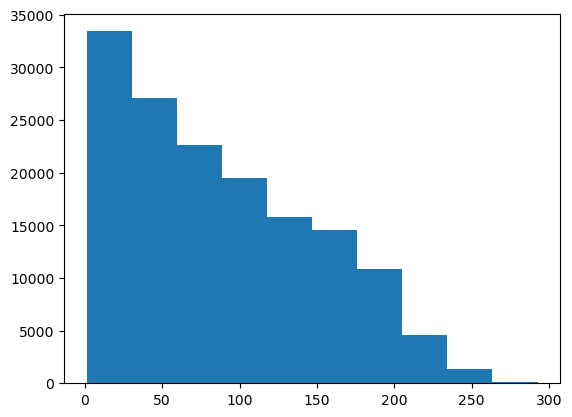

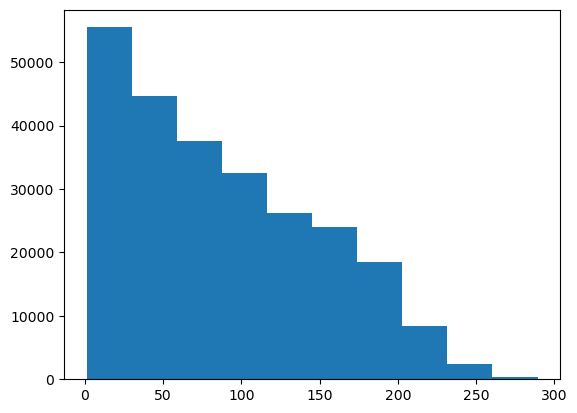

In [7]:
y_pred_train = best_rf.predict(X_val)
y_pred_test = best_rf.predict(X_test)

plt.figure(1)
plt.hist(y_pred_train)

plt.figure(2)
plt.hist(y_pred_test)

In [8]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error

val_mse = mean_squared_error(Y_val, y_pred_train)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(Y_val, y_pred_train)

y_pred_val_non_negative = np.maximum(0, y_pred_train)
val_msle = mean_squared_log_error(Y_val, y_pred_val_non_negative)
val_rmsle = np.sqrt(val_msle)

print(f"Validation MSLE: {val_msle}")
print(f"Validation RMSLE: {val_rmsle}")
print(f"Validation MSE: {val_mse}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation R2 Score: {val_r2}")

Validation MSLE: 0.003981864817411403
Validation RMSLE: 0.06310201912309465
Validation MSE: 14.067065861616005
Validation RMSE: 3.750608732141491
Validation R2 Score: 0.9963914947776096


In [ ]:
submission = pd.DataFrame({
    'id': df_test['id'],
    'Calories': y_pred_test
})

# Export to CSV
submission_name = 'RFv1_submission_1.csv'
submission.to_csv(submission_name, index=False)
print("✅ Submission file {} created using IDs from df_test!".format(submission_name))

✅ Submission file submission_6.csv created using IDs from df_test!
